In [0]:
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp

file_data   = "/content/drive/My Drive/Colab Notebooks/assignment-02/mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)


for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1
"""
#
# plot first 150 images out of 10,000 with their labels
#
f1 = plt.figure(1,(15,15))

for i in range(150):

    label       = list_label[i]
    im_vector   = list_image[:, i]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(10, 15, i+1)
    plt.title(label)
    f1.subplots_adjust(hspace = 2.3)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)


#plt.show()

#
# plot the average image of all the images for each digit
#
f2 = plt.figure(2)

im_average  = np.zeros((size_row * size_col, 10), dtype=float)
im_count    = np.zeros(10, dtype=int)

for i in range(num_image):

    im_average[:, list_label[i]] += list_image[:, i]
    im_count[list_label[i]] += 1

for i in range(10):

    im_average[:, i] /= im_count[i]

    plt.subplot(2, 5, i+1)
    plt.title(i)
    f2.subplots_adjust(hspace = 0.5)
    plt.imshow(im_average[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()


"""
q=1

In [0]:
def one_hot(label):
    one_hot.ones = cp.eye(10)
    #print(one_hot.ones[0].shape)
    #print(label.shape[0])
    for x in range (label.shape[0]):
        if (x == 0): 
            result = one_hot.ones[label[x]].view().reshape(1,-1)
        else:     
            result = cp.concatenate((result,one_hot.ones[label[x]].view().reshape(1,-1)), axis=0)
            
    #print(result.shape)
    #print(result.T[:,0])
    #print(label[0])
    return result.T

In [0]:
GT_train_image = cp.asarray(list_image[:,0:6000])
GT_train_label = one_hot(cp.asarray(list_label[0:6000]))
GT_test_image = cp.asarray(list_image[:,6000:num_image])
GT_test_label = one_hot(cp.asarray(list_label[6000:num_image]))

GT_train_label_raw = cp.asarray(list_label[0:6000])
GT_test_label_raw = cp.asarray(list_label[6000:num_image])

In [0]:
def sigmoid(x):
    return 1/(1+cp.exp(-x))

In [0]:


def h(X, th):
    bias = cp.ones(X.shape[1]).reshape(1,-1)

    a_1 = X
    a_1 = cp.concatenate((bias, a_1), axis=0)
    #print(a_1.shape)

    z_2 = cp.matmul(th[0], a_1)
    a_2 = sigmoid(z_2)
    a_2 = cp.concatenate((bias, a_2), axis=0)
    #print(a_2.shape)

    z_3 = cp.matmul(th[1], a_2)
    a_3 = sigmoid(z_3)
    a_3 = cp.concatenate((bias, a_3), axis=0)
    #print(a_3.shape)

    z_4 = cp.matmul(th[2], a_3)
    a_4 = sigmoid(z_4)
    #print(a_4.shape)
    return (a_4)

#h(GT_train_image, g_th).shape


In [0]:
def J(l, h):
    #print(l.shape)
    #print(h.shape)
    single = (-l*cp.log(h) - (1-l)*cp.log(1-h))
    return (1/h.shape[1])*cp.sum(single)



In [0]:
def backProp(X, th, l):
    bias = cp.ones(X.shape[1]).reshape(1,-1)

    a_1 = X
    a_1 = cp.concatenate((bias, a_1), axis=0)
    #print(a_1.shape)

    z_2 = cp.matmul(th[0], a_1)
    a_2 = sigmoid(z_2)
    a_2 = cp.concatenate((bias, a_2), axis=0)
    #print(a_2.shape)

    z_3 = cp.matmul(th[1], a_2)
    a_3 = sigmoid(z_3)
    a_3 = cp.concatenate((bias, a_3), axis=0)
    #print(a_3.shape)

    z_4 = cp.matmul(th[2], a_3)
    a_4 = sigmoid(z_4)
    #print(a_4.shape)

    d_4 = a_4 - l
    #print(d_4.shape)

    #print(th[2].T.shape)
    #print(d_4.shape)
    #print(a_3.shape)
    d_3 = cp.matmul(th[2].T, d_4) * (a_3* (1-a_3))
    #print(d_3.shape)

    #print(th[1].T.shape)
    #print(d_3[1:,:].shape)
    #print(a_2.shape)
    d_2 = cp.matmul(th[1].T, d_3[1:,:]) * (a_2* (1-a_2))
    #print(d_2.shape)


    # let's make del_theta
    #print(a_3.shape)
    #print(d_4.shape)
    for i in range(d_4.shape[0]):
        if (i == 0): 
            #print(a_3.shape)
            #print(d_4[i,:].shape) 
            DMAT_3 = cp.sum(a_3*d_4[i,:], axis=1).reshape(-1,1)
            #print(DMAT_3.shape)
        else:     
            #print(DMAT_3.shape)
            #print(cp.sum(a_3*d_4[i,:], axis=1).reshape(-1,1).shape)
            DMAT_3 = cp.concatenate((DMAT_3,cp.sum(a_3*d_4[i,:], axis=1).reshape(-1,1)), axis=1)
        #print((a_3*d_4[i,:]).shape)
    #print(DMAT_3.T.shape)
    for i in range(d_3.shape[0]):
        if (i == 0): #not in concern
            pass
        elif (i==1):
            DMAT_2 = cp.sum(a_2*d_3[i,:], axis=1).reshape(-1,1)
            #print(DMAT_2.shape)
        else:     
            DMAT_2 = cp.concatenate((DMAT_2,cp.sum(a_2*d_3[i,:], axis=1).reshape(-1,1)), axis=1)
    #print(DMAT_2.T.shape)
    for i in range(d_2.shape[0]):
        if (i == 0): 
            pass
        elif(i==1):
            DMAT_1 = cp.sum(a_1*d_2[i,:], axis=1).reshape(-1,1)
        else:     
            DMAT_1 = cp.concatenate((DMAT_1,cp.sum(a_1*d_2[i,:], axis=1).reshape(-1,1)), axis=1)
    #print(DMAT_1.T.shape)

    m = d_4.shape[1]
    result=[DMAT_1.T/m, DMAT_2.T/m, DMAT_3.T/m]
    return result




In [0]:
def GD(th, DMAT, lr):
    n_th = [th[0]-lr*DMAT[0], th[1]-lr*DMAT[1], th[2]-lr*DMAT[2]]
    return n_th

def accuracy(data, th, label):
    #print(h(data, th).shape)
    guess = cp.argmax(h(data, th), axis=0)
    #print(guess.shape)
    #print(label.shape)
    return cp.sum(cp.equal(label, guess)) / label.shape[0]

g_th = [cp.random.normal(size=(196, 785)), cp.random.normal(size=(49, 197)), cp.random.normal(size=(10,50))]


J_log_train = [J(GT_train_label,  h(GT_train_image, g_th))]
J_log_test = [J(GT_test_label,  h(GT_test_image, g_th))]

#print(accuracy(GT_train_image, g_th, GT_train_label_raw))
accuracy_train = [accuracy(GT_train_image, g_th, GT_train_label_raw)]
accuracy_test = [accuracy(GT_test_image, g_th, GT_test_label_raw)]

alpha = 0.03



In [24]:
from tqdm.notebook import tqdm
for i in tqdm(range(10000)):
    Dmat = backProp(GT_train_image, g_th, GT_train_label)
    g_th = GD(g_th, Dmat, alpha)
    J_log_train.append(J(GT_train_label, h(GT_train_image, g_th)))
    J_log_test.append(J(GT_test_label, h(GT_test_image, g_th)))
    accuracy_train.append(accuracy(GT_train_image, g_th, GT_train_label_raw))
    accuracy_test.append(accuracy(GT_test_image, g_th, GT_test_label_raw))



1. Plot the loss curve

plot the training loss at every iteration of gradient descent using the training data in blue color (the first 6,000 images) [5pt]


plot the testing loss at every iteration of gradient descent using the testing data in red color (the rest 4,000 images) [5pt]


the both curves should be presented in one figure

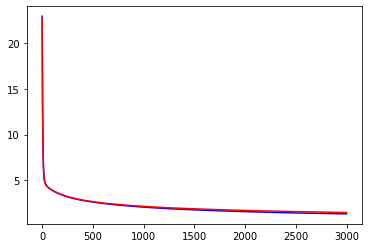

In [25]:
plt.plot(J_log_train,c='blue')
plt.plot(J_log_test,c='red')
plt.show()

2. Plot the accuracy curve

plot the training accuracy (%) at every iteration of gradient descent using the training data in blue color (the first 6,000 images) [5pt]


plot the testing accuracy (%) at every iteration of gradient descent using the testing data in red color (the rest 4,000 images) [5pt]


the both curves should be presented in one figure

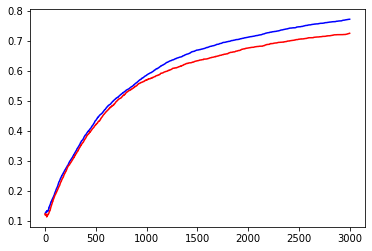

In [26]:
plt.plot(accuracy_train,c='blue')
plt.plot(accuracy_test,c='red')
plt.show()

3. Plot the accuracy value

print the final training accuracy (%) using the training data (the first 6,000 images) [2pt]


print the final testing accuracy (%) using the testing data (the rest 4,000 images) [2pt]



In [0]:
print(accuracy_train[-1] * 100, "%")
print(accuracy_test[-1] * 100, "%")

4. Plot the classification example

present 10 correctly classified testing images with their labels at the title of each sub-figure in 2x5 array [5pt]


present 10 misclassified testing images with their misclassified labels at the title of each sub-figure in 2x5 array [5pt]

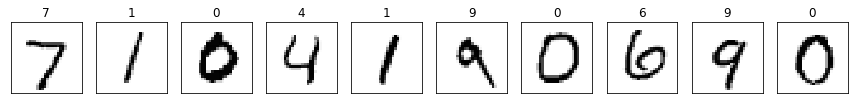

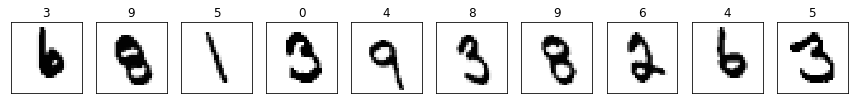

In [47]:
label= GT_train_label_raw
guess = cp.argmax(h(GT_train_image, g_th), axis=0)
#print(cp.equal(label, guess).shape)
right = cp.equal(label, guess)
#print(GT_train_image[:, np.where(right==True)[0]].shape)


guess = cp.asnumpy(guess[np.where(right==True)[0]])
img = cp.asnumpy(GT_train_image[:, np.where(right==True)[0]])

f1 = plt.figure(1,(15,15))

for i in range(10):

    label       = guess[i]
    im_vector   = img[:, i]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(3, 10, i+1)
    plt.title(label)
    f1.subplots_adjust(hspace = 2.3)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)



label= GT_test_label_raw
guess = cp.argmax(h(GT_test_image, g_th), axis=0)

right = cp.equal(label, guess)


guess = cp.asnumpy(guess[np.where(right==False)[0]])
img = cp.asnumpy(GT_test_image[:, np.where(right==False)[0]])

f2 = plt.figure(4,(15,15))

for i in range(10):

    label       = guess[i]
    im_vector   = img[:, i]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(1, 10, i+1)
    plt.title(label)
    f1.subplots_adjust(hspace = 2.3)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

